# Sentiment Analysis on Playstore reviews
**By Sanju S**

*For Edunet AICTE Internship*

**Step 1:** Import all required libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
import spacy
from wordcloud import WordCloud, STOPWORDS
from PIL import Image

In [3]:
from nltk.corpus import stopwords
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,classification_report
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
import xgboost as xgb
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings('ignore')

In [5]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

**Step 2:** Import CSV file

In [65]:
data = pd.read_csv('Reviews.csv')

In [66]:
data.head()

,Unnamed: 0,rating,review
0,0,4,25-07-2023 15:01:00. What type this app
1,1,5,25-07-2023 15:01:00. I am the first one 😁😁
2,2,5,25-07-2023 15:02:00. Bahut Achcha work
3,3,4,25-07-2023 15:03:00. Pretty good UI
4,4,5,25-07-2023 15:03:00. First


**Step 3:** Clean, preprocess, tokenize and lemmatize the data

In [7]:
data['review'] = data['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [8]:
data['review'] = data['review'].str.replace('[^\w\s]','')

In [9]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
data['review'] = data['review'].apply(lambda x: remove_emoji(x))

In [10]:
stop = stopwords.words('english')
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

In [11]:
def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
data['review']= data['review'].apply(space)

In [12]:
# Remove neutral words
words_to_remove = ['chatgpt','app','chatgpts','chat','gpt','android','gpt4','phone','number','ai','use','io']
data['review'] = data['review'].apply(lambda x: " ".join(x for x in x.split() if x not in words_to_remove))

In [13]:
data['rating'] = data['rating'].apply(lambda rating: 2 if rating > 3 else (1 if rating == 3 else 0))

In [14]:
token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english',ngram_range = (1,1),tokenizer = token.tokenize)
X = cv.fit_transform(data['review'])
y = data['rating']

In [15]:
y=data['rating']

In [16]:
# Oversampling using SMOTE
smote = SMOTE()

X_oversampled, y_oversampled = smote.fit_resample(X, y)

In [17]:
# Feature extraction
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['review'])
y = data['rating']

**Step 4:** Split the dataset for training and testing

In [18]:
#Train Test split
X_train, X_test, y_train, y_test = train_test_split(X_oversampled,
                                                  y_oversampled,
                                                  test_size=0.20,
                                                  random_state=17,stratify=y_oversampled)

In [19]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay




---


**Step 5: Test Different classification models and algorithms one-by-one**

# 1. Multinomial model

Accuracy Score: 0.675144272509065

-------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.55      0.69      0.62      5201
           1       0.78      0.55      0.64      9232
           2       0.69      0.88      0.78      5148

    accuracy                           0.68     19581
   macro avg       0.68      0.71      0.68     19581
weighted avg       0.70      0.68      0.67     19581


-------------------------------------------------------------------------


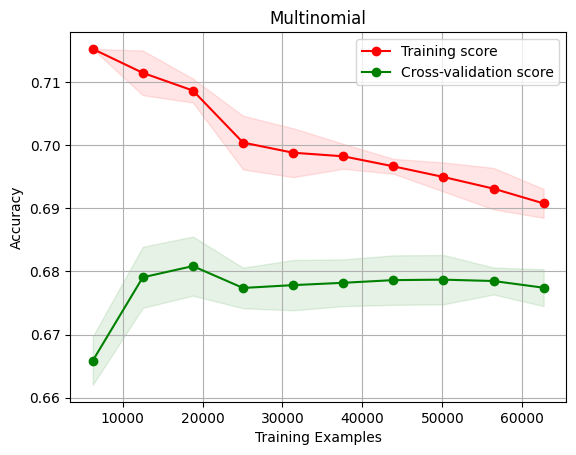

In [50]:
#Training the model
MNB = MultinomialNB()
MNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = MNB.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print()
print('-------------------------------------------------------------------------')
print('Classification Report: ')
print(classification_report(y_pred, y_test))
print()
print('-------------------------------------------------------------------------')

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(MNB, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Multinomial')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

# Plot the shaded areas for standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

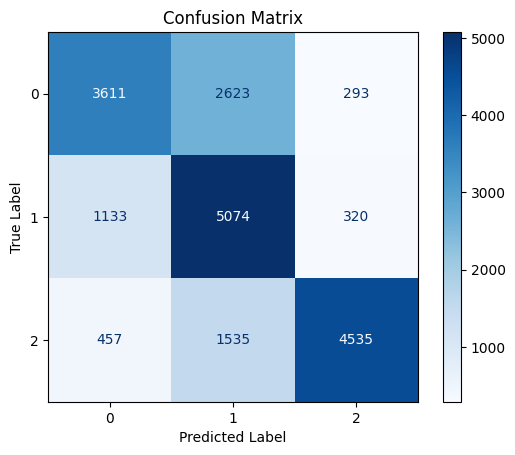

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = MNB.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=MNB.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=MNB.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add title and labels for better visualization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# 2. Bernoulli Model

Accuracy Score: 0.6661559675195342

-------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.49      0.71      0.58      4467
           1       0.85      0.54      0.66     10266
           2       0.66      0.89      0.76      4848

    accuracy                           0.67     19581
   macro avg       0.67      0.71      0.67     19581
weighted avg       0.72      0.67      0.67     19581


-------------------------------------------------------------------------


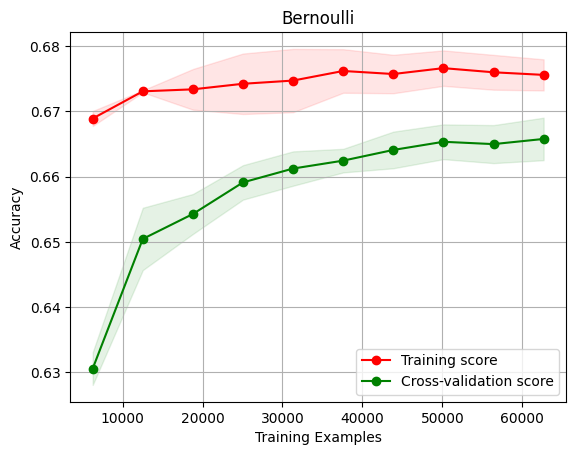

In [52]:
#Training the model
BNB = BernoulliNB()
BNB.fit(X_train, y_train)

#Caluclating the accuracy score of the model
y_pred = BNB.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print()
print('-------------------------------------------------------------------------')
print('Classification Report: ')
print(classification_report(y_pred, y_test))
print()
print('-------------------------------------------------------------------------')

# model = LogisticRegression(solver='liblinear')

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(BNB, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Bernoulli')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

# Plot the shaded areas for standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

plt.legend(loc='best')
plt.show()

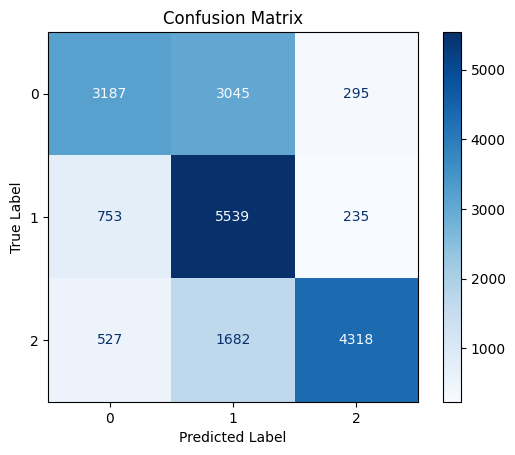

In [53]:
y_pred = BNB.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=BNB.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=BNB.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add title and labels for better visualization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# 3. Logistic Regression Algorithm

Accuracy Score: 0.7886726929166028

-------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.65      0.73      0.69      5791
           1       0.74      0.71      0.73      6794
           2       0.97      0.91      0.94      6996

    accuracy                           0.79     19581
   macro avg       0.79      0.78      0.79     19581
weighted avg       0.80      0.79      0.79     19581


-------------------------------------------------------------------------


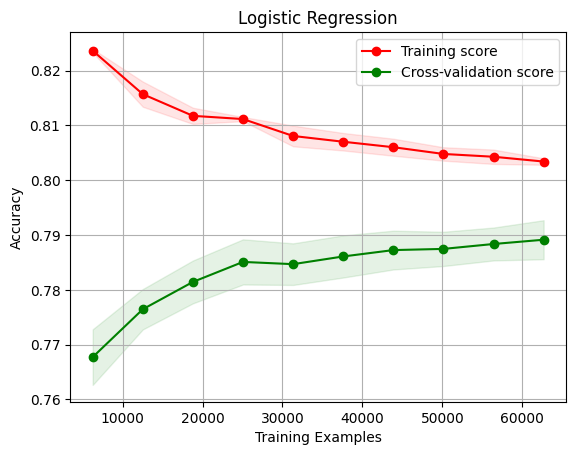

In [54]:
# Logistic Regression
LG = LogisticRegression()
LG.fit(X_train, y_train)

# Predict and calculate metrics
y_pred = LG.predict(X_test)

print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print()
print('-------------------------------------------------------------------------')
print('Classification Report: ')
print(classification_report(y_pred, y_test))
print()
print('-------------------------------------------------------------------------')

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(LG, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Logistic Regression')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

# Plot the shaded areas for standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Display Accuract Curves
plt.legend(loc='best')
plt.show()

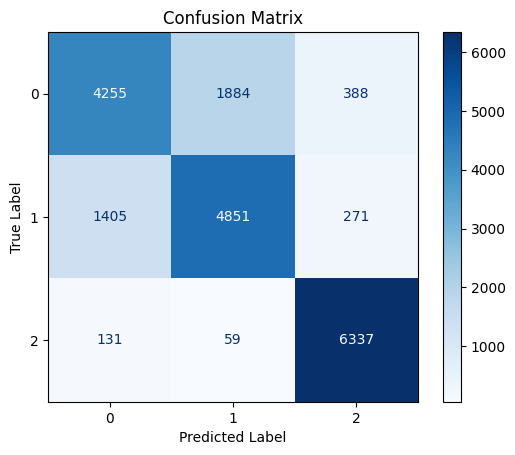

In [55]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = LG.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=LG.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=LG.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add title and labels for better visualization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# 4. Random Forest Classification Algorithm

Accuracy Score: 0.8111945253051427

-------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.78      0.75      0.76      6759
           1       0.86      0.78      0.82      7220
           2       0.80      0.93      0.86      5602

    accuracy                           0.81     19581
   macro avg       0.81      0.82      0.81     19581
weighted avg       0.81      0.81      0.81     19581


-------------------------------------------------------------------------


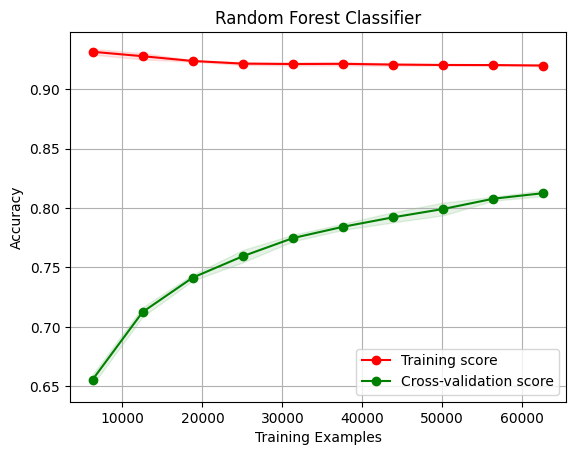

In [62]:
# Random Forest Classification
RFC = RandomForestClassifier(n_estimators=10)
RFC.fit(X_train, y_train)

# Predict and calculate metrics
y_pred = RFC.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print()
print('-------------------------------------------------------------------------')
print('Classification Report: ')
print(classification_report(y_pred, y_test))
print()
print('-------------------------------------------------------------------------')

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(RFC, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Random Forest Classifier')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

# Plot the shaded areas for standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Display Accuracy Curves
plt.legend(loc='best')
plt.show()

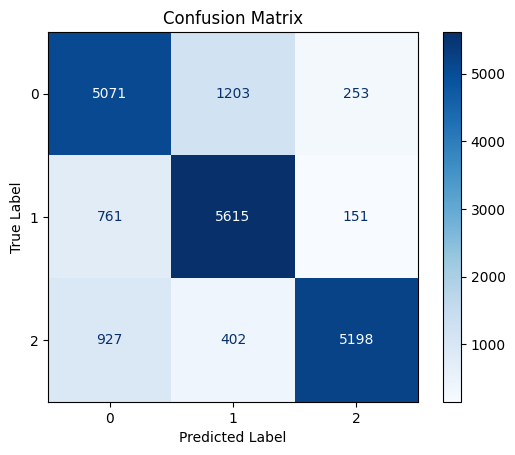

In [63]:
# Confusion Matrix
y_pred = RFC.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=RFC.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=RFC.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add title and labels for better visualization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# 5. Decision Tree Classifier Algorithm

Accuracy Score: 0.7787140595475206

-------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.76      0.73      0.75      6803
           1       0.86      0.73      0.79      7700
           2       0.72      0.92      0.81      5078

    accuracy                           0.78     19581
   macro avg       0.78      0.79      0.78     19581
weighted avg       0.79      0.78      0.78     19581


-------------------------------------------------------------------------


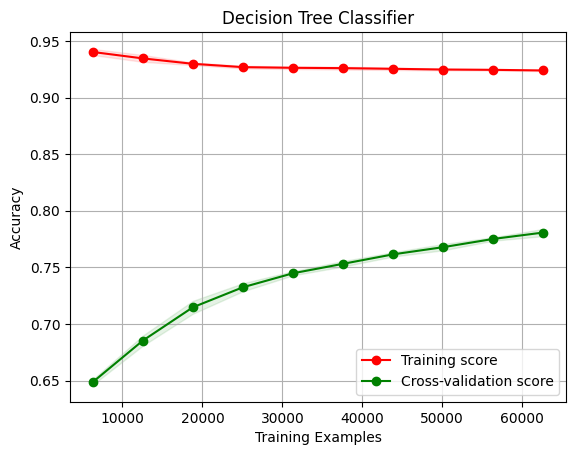

In [58]:
# Decision Tree Classifier
from sklearn.tree import DecisionTreeClassifier

DTC = DecisionTreeClassifier()
DTC.fit(X_train, y_train)

# Predict and report metrics
y_pred = DTC.predict(X_test)
print(f'Accuracy Score: {accuracy_score(y_test, y_pred)}')
print()
print('-------------------------------------------------------------------------')
print('Classification Report: ')
print(classification_report(y_pred, y_test))
print()
print('-------------------------------------------------------------------------')

# Generate learning curve
train_sizes, train_scores, test_scores = learning_curve(DTC, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# Calculate mean and standard deviation of training and test scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Plot the learning curve
plt.figure()
plt.title('Decision Tree Classifier')
plt.xlabel('Training Examples')
plt.ylabel('Accuracy')
plt.grid()

# Plot the shaded areas for standard deviation
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color='g')

# Plot the mean training and test scores
plt.plot(train_sizes, train_scores_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_scores_mean, 'o-', color='g', label='Cross-validation score')

# Display Accuracy Curves
plt.legend(loc='best')
plt.show()

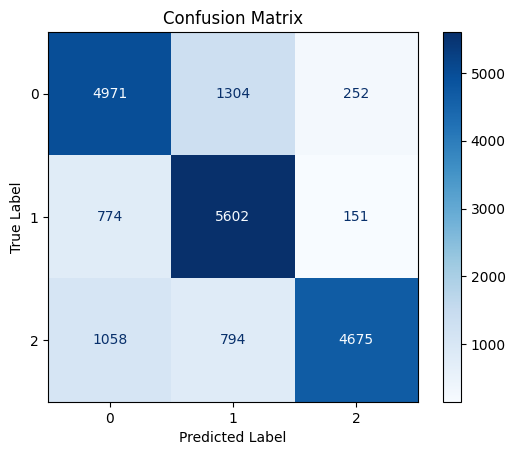

In [59]:
# Confusion Matrix
y_pred = DTC.predict(X_test)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=DTC.classes_)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=DTC.classes_)
disp.plot(cmap=plt.cm.Blues)

# Add title and labels for better visualization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# 6. XGBoost Model

Accuracy Score: 0.9184413462029518

-------------------------------------------------------------------------
Classification Report: 
              precision    recall  f1-score   support

           0       0.85      0.95      0.90      5868
           1       0.91      0.92      0.92      6483
           2       0.99      0.89      0.94      7230

    accuracy                           0.92     19581
   macro avg       0.92      0.92      0.92     19581
weighted avg       0.92      0.92      0.92     19581


-------------------------------------------------------------------------


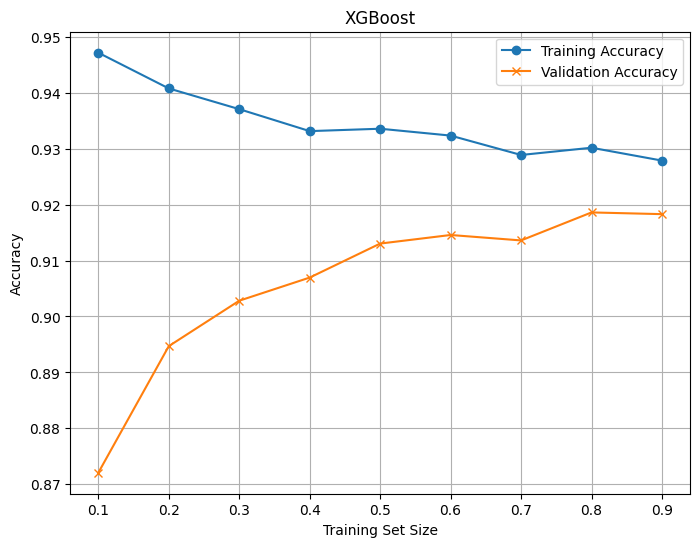

In [60]:
# XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Hyper-parameters
params = {
    'objective': 'multi:softmax',
    'num_class': 3, # Classes: Positive, Negative and Neutral
    'eval_metric': 'merror',
    'eta': 0.4,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 104
}

num_rounds = 100
XGB = xgb.train(params, dtrain, num_rounds)

# Predict and report metrics
preds = XGB.predict(dtest)
pred_labels = [int(pred) for pred in preds]

print(f'Accuracy Score: {accuracy_score(y_test, pred_labels)}')
print()
print('-------------------------------------------------------------------------')
print('Classification Report: ')
print(classification_report(pred_labels, y_test))
print()
print('-------------------------------------------------------------------------')

# Draw accuracy graph
def plot_learning_curve(params, X, y, num_rounds, train_sizes):
    train_accuracies = []
    test_accuracies = []

    for train_size in train_sizes:
        X_train_part, _, y_train_part, _ = train_test_split(X, y, train_size=train_size, random_state=42)

        dtrain = xgb.DMatrix(X_train_part, label=y_train_part)
        dtest = xgb.DMatrix(X_test, label=y_test)

        model = xgb.train(params, dtrain, num_rounds)
        preds_train = model.predict(dtrain)
        preds_test = model.predict(dtest)

        train_accuracy = accuracy_score(y_train_part, preds_train)
        test_accuracy = accuracy_score(y_test, preds_test)

        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)

    plt.figure(figsize=(8, 6))
    plt.plot(train_sizes, train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(train_sizes, test_accuracies, label='Validation Accuracy', marker='x')
    plt.title('XGBoost')
    plt.xlabel('Training Set Size')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

train_sizes = np.linspace(0.1, 0.9, 9)

# Plot And Display Accuracy Curves
plot_learning_curve(params, X_train, y_train, num_rounds, train_sizes)

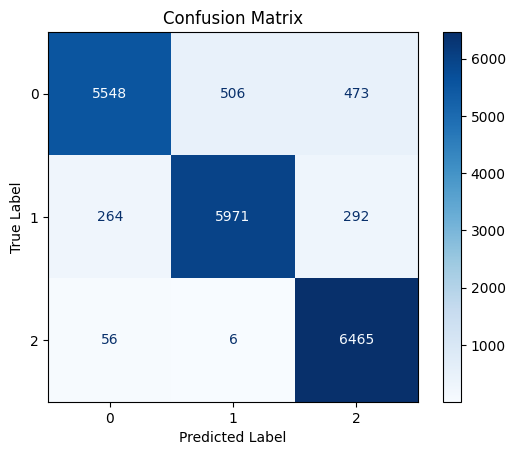

In [61]:
# Confusion Matrix:
y_pred = XGB.predict(dtest)

# Compute the confusion matrix
cm = confusion_matrix(y_test, pred_labels)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues)

# Add title and labels for better visualization
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Show the plot
plt.show()

# Final Results

Accuracies:

**Multinomial:** 0.68

**Bernoulli:** 0.67

**Logical Regression:** 0.79

**Random Forest Classifier:** 0.81

**Decision Tree Classifier:** 0.78

**XGBoost:** 0.92



# Conclusion:
# XGBoost is the most efficient algorithm with an acccuracy of 92%

